# Load necessary packages

In [1]:
import urllib.request, json 
import pandas as pd
from datetime import datetime, timezone, timedelta
import time
from dateutil.parser import parse
from dateutil import tz
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import joblib
import collections
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
def API_reader(link, param =""):
    """This function calls the NHL API and returns a file in a Dictionary format."""
    with urllib.request.urlopen(link + param) as url:
        data = json.loads(url.read().decode())
    return(data)

# Find all the game ids for games being played today

In [3]:
def NHL_games_today(todays_date, print_binary = 0):
    """This function looks at all the games being played today (or input any date in 'YYYY-MM-DD' format) then finds their 
    starting times, and sorts them by starting time. Then it calculates how long to wait between starting times."""
    games_links = f"https://statsapi.web.nhl.com/api/v1/schedule?startDate={todays_date}&endDate={todays_date}"
    #games_links = f"https://statsapi.web.nhl.com/api/v1/schedule?startDate=2020-01-02&endDate=2020-01-02"
    dates = API_reader(games_links)
    num_of_games = dates["totalGames"]
    games_id_list = [dates["dates"][0]["games"][i]["gamePk"] for i in range(num_of_games)]
    #Find the difference in seconds between the start times.
    if len(games_id_list) > 1:
        start_times = []
        game_start_dict = {}
        for game_id in games_id_list:
            data = API_reader(f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live")
            start_time = data["gameData"]["datetime"]["dateTime"]
            game_start_dict[str(game_id)] = start_time
            start_time = parse(start_time)
            start_times.append(start_time)
            start_times = sorted(start_times)
        delta_seconds_start_times = [(start_times[i+1]- start_times[i]).total_seconds() for i in range(len(start_times)-1)]+ [0]
    else:
        delta_seconds_start_times = [0]
    # Solution to sorting a dict found here: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    game_start_dict = {k : v for k, v in sorted(game_start_dict.items(), key=lambda item: item[1])}
    games_id_list =[int(j) for j in [k for k in game_start_dict.keys()]]
    if print_binary == 1:
        print(f"Number of Games on {todays_date}:", len(games_id_list))
        print("Game Ids: ", games_id_list)
        print("Time (seconds) between start times:", delta_seconds_start_times)
        print("Number of unique start times:", len(set(start_times)))
    return((games_id_list, delta_seconds_start_times, game_start_dict, start_times))

In [4]:
def regroup_games_by_start_times(games_id_list):
    """Gruop the games into lists according to start times. Any games that have the same start time 
    are put into the same list."""
    #In order to group the games by their start times I need to reformat the dictionary.
    game_start_dict_reformatted = []
    for i in range(len(games_id_list)): 
        game_start_dict_reformatted.append({"game" : games_id_list[i], "start_time" : start_times[i]})
    #Grouping dictionary items: https://www.saltycrane.com/blog/2014/10/example-using-groupby-and-defaultdict-do-same-task/
    grouped = collections.defaultdict(list)
    for item in game_start_dict_reformatted:
        grouped[item['start_time']].append(item)    
    game_start_list = []
    for i in grouped.items():
        game_start_list.append(i[1])
    # Now create a list of the games according to their start times.
    games_grouped_by_start = []
    for j in range(len(game_start_list)):
        groups_of_start_times = []
        for i in range(len(game_start_list[j])):
            groups_of_start_times.append(game_start_list[j][i]["game"])
        games_grouped_by_start.append(groups_of_start_times)
    #print(len(games_grouped_by_start))    
    return(games_grouped_by_start)

In [5]:
#https://stackoverflow.com/questions/3173154/move-an-item-inside-a-list
def order_same_start_times(games_id_sublist):
    """Even though games have the same start times, due to pre-game activities they may start up to 15 minutes after
    one another. This function takes the time remaining midway through the period and reorders the games with the
    same start times according to which one will get to the first intermission first."""
    time_remaining = []
    for game_id in games_id_sublist:
        game_link = f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live"
        data = API_reader(game_link)
        time_remaining.append(data["liveData"]["linescore"]["currentPeriodTimeRemaining"])
    time_remaining_dict = dict(zip(games_id_sublist, time_remaining))
    time_remaining_dict = {k : v for k,v in sorted(time_remaining_dict.items(), key = lambda item: item[1])}
    game_id_values = list(time_remaining_dict.values())
    game_id_keys = list(time_remaining_dict.keys())
    for i in range(len(game_id_values)):
        if game_id_values[i] == "END":
            game_id_keys.insert(0, game_id_keys.pop(i))
    return(game_id_keys)

In [6]:
#Extract the win, loss, OT records for each team playing.
def _team_records(game_id):  
    """This function is used to extract the team records for the teams playing today."""
    game_link = f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live"
    data = API_reader(game_link)
    away_team_id = data["gameData"]["teams"]["away"]["id"]
    home_team_id = data["gameData"]["teams"]["home"]["id"]
    for team_id in ([away_team_id] + [home_team_id]):
        team_link = f"https://statsapi.web.nhl.com/api/v1/schedule?teamId={team_id}"
        team_id_data = API_reader(team_link)
        home_record = list(team_id_data["dates"][0]["games"][0]["teams"]["home"]["leagueRecord"].values())[:3]
        away_record = list(team_id_data["dates"][0]["games"][0]["teams"]["away"]["leagueRecord"].values())[:3]
    return(home_record + away_record)

In [7]:
def differences(df):
    """Used to calculate the feature differences between the home and away teams, and to
    convert the percentage features to numeric."""
    df["Win_Diff"] = df["Home_wins"] - df["Away_wins"]
    df["Loss_Diff"] = df["Home_losses"] - df["Away_losses"]
    df["OT_Diff"] = df["Home_OT"] - df["Away_OT"]
    df["Goals_Diff"] = df["Home_goals"] - df["Away_goals"]
    df["Shots_Diff"] = df["Home_shots"] - df["Away_shots"]
    df["Blocked_Diff"] = df["Home_blocked"] - df["Away_blocked"]
    df["PIM_Diff"] = df["Home_pim"] - df["Away_pim"]
    df["PowerPlayGoals_Diff"] = df["Home_powerPlayGoals"] - df["Away_powerPlayGoals"]
    df["Takeaways_Diff"] = df["Home_takeaways"] - df["Away_takeaways"]
    df["Giveaways_Diff"] = df["Home_giveaways"] - df["Away_giveaways"]
    df["Hits_Diff"] = df["Home_hits"] - df["Away_hits"]
    df["Home_powerPlayPercentage"] = pd.to_numeric(df["Home_powerPlayPercentage"])/100
    df["Away_powerPlayPercentage"] = pd.to_numeric(df["Away_powerPlayPercentage"])/100
    df["Home_faceOffWinPercentage"] = pd.to_numeric(df["Home_faceOffWinPercentage"])/100
    df["Away_faceOffWinPercentage"] = pd.to_numeric(df["Away_faceOffWinPercentage"])/100
    return(df)

# Find all the first period stats for the games being played today

In [8]:
def feature_engineering(prep_df, specific_game_id):
    """This function prepares a teams's first period stats for prediction"""
   #df_vars_for_prediction = pd.DataFrame(columns = some_columns + home_team_categories + away_team_categories)
    df_vars_for_prediction = pd.DataFrame(columns = list(prep_df.columns))
    #df_vars_for_prediction.loc[str(specific_game_id)] = home_team + away_team + team_record + home_team_values + away_team_values
    df_vars_for_prediction.loc[str(specific_game_id)] = prep_df.loc[str(specific_game_id)]
    df_vars_for_prediction = differences(df_vars_for_prediction)
    df_vars_for_prediction["Points_Diff"] = (df_vars_for_prediction["Home_wins"]*2 - df_vars_for_prediction["Away_wins"]*2) + (df_vars_for_prediction["Home_OT"] - df_vars_for_prediction["Away_OT"])
    df_vars_for_prediction = df_vars_for_prediction.drop(columns = ["Home_team", "Away_team", "Home_wins", "Home_losses", \
                        "Home_OT","Away_wins", "Away_losses", "Away_OT", \
                          "Win_Diff", "Loss_Diff", "OT_Diff", "Away_faceOffWinPercentage"])
    df_vars_for_prediction.astype(float)

    df_vars_for_prediction.reset_index(level = 0, inplace = True)
    variables =  df_vars_for_prediction.loc[0]
    variables = variables.to_numpy().reshape(1,-1)
    return((model_from_joblib.predict(variables), model_from_joblib.predict_proba(variables)))

In [9]:
def calculate_stats(df, games_id_sublist, game_counter, per = 1, state = "END"):
    """This function calcualtes all the available team stats after the specified period for a game. The default
    period is set to 1. This function returns a dataframe and the game counter for the day."""
    Start_time_counter = 0
    #game_counter = 0
    for game_id in games_id_sublist:
        Period = 0 
        while Period < 1:
            game_link = f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live"
            data = API_reader(game_link)
            if data["liveData"]["linescore"]["currentPeriod"] == per and data["liveData"]["linescore"]["currentPeriodTimeRemaining"] == state: 
                team_record = _team_records(game_id)
                some_columns = ["Home_team", "Away_team", "Home_wins", "Home_losses", "Home_OT", "Away_wins", "Away_losses", "Away_OT"]
                home_team_categories = list(data['liveData']['boxscore']['teams']['home']['teamStats']['teamSkaterStats'].keys())
                away_team_categories = list(data['liveData']['boxscore']['teams']['away']['teamStats']['teamSkaterStats'].keys())
                home_team_categories = [f"Home_{i}" for i in home_team_categories]
                away_team_categories = [f"Away_{i}" for i in away_team_categories]
                home_team = [data["gameData"]["teams"]["home"]["triCode"]]
                away_team = [data["gameData"]["teams"]["away"]["triCode"]]
                df.columns = some_columns + home_team_categories + away_team_categories
                away_team_stats = data['liveData']['boxscore']['teams']['away']['teamStats']['teamSkaterStats']
                home_team_stats = data['liveData']['boxscore']['teams']['home']['teamStats']['teamSkaterStats']
                home_team_values = list(home_team_stats.values())
                away_team_values = list(away_team_stats.values())
                df.loc[str(game_id)] = home_team + away_team + team_record + home_team_values + away_team_values
                Period = 1
                game_counter += 1
                #df.to_csv(f"C:\\Users\\David\\OneDrive\\Documents\\OneDrive\\NHL API First period Prediction\\IntermediateDatasets\\{todays_date}_raw.csv", index = True)
                print("Game ", str(game_counter) ,"/", str(len(games_id_list)), f"ID: {game_id} ({away_team[0]}@{home_team[0]}) completed at: ", str(datetime.today().hour), ":", str(datetime.today().minute))
                #print(df)
                prediction = feature_engineering(df, game_id)[0]
                prediction_probs = feature_engineering(df, game_id)[1]
                if int(prediction) == 0:
                    print(f"The team that is predicted to win is: {home_team[0]} with probability {round(prediction_probs[0][0]*100,2)}%")
                else:
                    print(f"The team that is predicted to win is: {away_team[0]} with probability {round(prediction_probs[0][1]*100,2)}%")
                Start_time_counter += 1
            else:
                Period = 0
                print("Check Point: ", datetime.today().hour, ":", datetime.today().minute)
                time.sleep(60*4)
    return((df, game_counter))

In [10]:
model_from_joblib = joblib.load("C:\\Users\\David\\OneDrive\\Documents\\OneDrive\\NHL API First period Prediction\\Classifier_Model.pkl")
todays_date = str(datetime.today().year) + "-" + str(datetime.today().month) + "-" + str(datetime.today().day)
#todays_date = "2020-1-21"
games_id_list = NHL_games_today(todays_date, 1)[0]
delta_seconds_start_times = NHL_games_today(todays_date)[1]
game_start_dict = NHL_games_today(todays_date)[2]
start_times = NHL_games_today(todays_date)[3]
delta_seconds_start_times_unique = [x for x in delta_seconds_start_times if x != 0.0 and type(x) == float]
delta_seconds_start_times_unique = delta_seconds_start_times_unique + [600]
list_of_groups = regroup_games_by_start_times(games_id_list)
print("Game IDs organized by Start Time:", list_of_groups)

Number of Games on 2020-2-2: 3
Game Ids:  [2019020806, 2019020807, 2019020808]
Time (seconds) between start times: [5400.0, 0.0, 0]
Number of unique start times: 2
Game IDs organized by Start Time: [[2019020806], [2019020807, 2019020808]]


In [11]:
#https://stackoverflow.com/questions/4563272/convert-a-python-utc-datetime-to-a-local-datetime-using-only-python-standard-lib
first_game = list_of_groups[0][0]
def when_to_start(first_game):
    game_link = f"https://statsapi.web.nhl.com/api/v1/game/{first_game}/feed/live"
    data = API_reader(game_link)
    game_start_time = parse(data["gameData"]["datetime"]["dateTime"])
    current_time = datetime.now(timezone.utc)
    delta_seconds_to_first_start_time = (game_start_time - current_time).seconds
    delta_days_to_first_start_time = (game_start_time - current_time).days
    next_start_up_time = current_time + timedelta(seconds = delta_seconds_to_first_start_time + 60*40)
    next_start_up_time = next_start_up_time.astimezone(tz.tzlocal())
    timestampStr = next_start_up_time.strftime("%H:%M")
    print("Current time: ", datetime.today().hour, ":", datetime.today().minute)
    print('Next Start Time : ', timestampStr)
    if delta_days_to_first_start_time >= 0:
        print("Sleeping until the first game, which is in: ", round((delta_seconds_to_first_start_time/60 + 40),0), f"minutes (approximately {timestampStr}).")
        time.sleep(delta_seconds_to_first_start_time + 60*40)
    print(delta_seconds_to_first_start_time+ 60*40)
when_to_start(first_game)

Current time:  5 : 41
Next Start Time :  10:09
Sleeping until the first game, which is in:  268.0 minutes (approximately 10:09).
16109


In [12]:
game_counter = 0
df = pd.DataFrame(columns = [i for i in range(30)])
for i in range(0,len(list_of_groups)):
    new_order = order_same_start_times(list_of_groups[i])
    #print(new_order)
    stats_output = calculate_stats(df, new_order, game_counter)#[1]
    df = stats_output[0]
    game_counter = stats_output[1]
    print("Now sleeping for", str(delta_seconds_start_times_unique[i]/60-10),"minutes")
    time.sleep(delta_seconds_start_times_unique[i]-60*10)

Check Point:  10 : 10
Check Point:  10 : 14
Game  1 / 3 ID: 2019020806 (PIT@WSH) completed at:  10 : 18
The team that is predicted to win is: PIT with probability 90.0%
Now sleeping for 80.0 minutes
Check Point:  11 : 38
Check Point:  11 : 42
Game  2 / 3 ID: 2019020807 (CBJ@MTL) completed at:  11 : 46
The team that is predicted to win is: CBJ with probability 69.0%
Check Point:  11 : 46
Game  3 / 3 ID: 2019020808 (VAN@CAR) completed at:  11 : 50
The team that is predicted to win is: VAN with probability 78.0%
Now sleeping for 0.0 minutes


In [ ]:
#time.sleep(60*40*6)
#df = pd.DataFrame(columns = [i for i in range(30)])
#new_order = order_same_start_times(list_of_groups[0])
#print(new_order)
#game_counter = 0
#stats_output = calculate_stats(df, new_order, game_counter)
#df = stats_output[0]
#game_counter = stats_output[1]
#print(df)

In [ ]:
#new_order = order_same_start_times(list_of_groups[1])
#print(new_order)
#stats_output = calculate_stats(df, new_order, game_counter)
#df = stats_output[0]
#game_counter = stats_output[1]
#print(df)

# Calculate the differences between the home and away team statistics and add them as features in the dataset.

In [13]:
df_all_features = differences(df)
df_all_features.to_csv(f"C:\\Users\\David\\OneDrive\\Documents\\OneDrive\\NHL API First period Prediction\\IntermediateDatasets\\{todays_date}_df_all_features.csv", index = True)

In [36]:
last_game_id = df_all_features.iloc[df_all_features.shape[0]-1].name
last_game_id = 2019020809
print(last_game_id)
game_link = f"https://statsapi.web.nhl.com/api/v1/game/{last_game_id}/feed/live"
data = API_reader(game_link)
print(data["gameData"]["status"]["abstractGameState"])
time_counter = 0
while time_counter < 1:
    if data["gameData"]["status"]["abstractGameState"] != "Final":
        time.sleep(4)
        print(time_counter)
        print(data["gameData"]["status"]["abstractGameState"])
        print(type(data["gameData"]["status"]["abstractGameState"]))
        time_counter = 0
    else:
        print("Calculate winners")
        time_counter = 1

2019020809
Preview
{0}
Preview
<class 'str'>
{0}
Preview
<class 'str'>
{0}
Preview
<class 'str'>


KeyboardInterrupt: 

In [14]:
#for calculating the winners
last_game_id = df_all_features.iloc[df_all_features.shape[0]-1].name
print(last_game_id)
game_link = f"https://statsapi.web.nhl.com/api/v1/game/{last_game_id}/feed/live"
data = API_reader(game_link)
time_counter = 0
while time_counter < 1:
    if data["gameData"]["status"]["abstractGameState"] != "Final":
        print("Sleeping for 45 minutes. Current time: ", datetime.today().hour, ":", datetime.today().minute)
        print(data["gameData"]["status"]["abstractGameState"])
        print(type(data["gameData"]["status"]["abstractGameState"]))
        time_counter = 0
        time.sleep(60*15)
    else:
        time_counter = 1
        for game_id in games_id_list:
            game_link = f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live"
            data = API_reader(game_link)
            home_team = data["gameData"]["teams"]["home"]["triCode"]
            away_team = data["gameData"]["teams"]["away"]["triCode"]
            num_periods = len(data["liveData"]["linescore"]["periods"])
            if data["liveData"]["linescore"]["hasShootout"] == False:
                if sum([int(data["liveData"]["linescore"]["periods"][i]["home"]["goals"]) for i in range(num_periods)]) > \
                    sum([int(data["liveData"]["linescore"]["periods"][i]["away"]["goals"]) for i in range(num_periods)]):#2 for the third period, using 0 indexing
                    print(f"{home_team} Wins")
                    df_all_features.loc[str(game_id), "Winner"] = home_team
                    df_all_features.loc[str(game_id), "Winner_binary"] = 0
                else: 
                    print(f"{away_team} Wins")
                    df_all_features.loc[str(game_id), "Winner"] = away_team
                    df_all_features.loc[str(game_id), "Winner_binary"] = 1
            else:
                if int(data["liveData"]["linescore"]["shootoutInfo"]["home"]["scores"]) > \
                    int(data["liveData"]["linescore"]["shootoutInfo"]["away"]["scores"]):#2 for the third period, using 0 indexing
                    print(f"{home_team} Wins")
                    df_all_features.loc[str(game_id), "Winner"] = home_team
                    df_all_features.loc[str(game_id), "Winner_binary"] = 0
                else: 
                    print(f"{away_team} Wins")
                    df_all_features.loc[str(game_id), "Winner"] = away_team
                    df_all_features.loc[str(game_id), "Winner_binary"] = 1

2019020808
Sleeping for 45 minutes. Current time:  11 : 50
Sleeping for 45 minutes. Current time:  12 : 35
Sleeping for 45 minutes. Current time:  13 : 20
Sleeping for 45 minutes. Current time:  14 : 5
Sleeping for 45 minutes. Current time:  14 : 50


KeyboardInterrupt: 

# Report the Winner

In [15]:
#time.sleep(60*90)
for game_id in games_id_list:
    game_link = f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live"
    data = API_reader(game_link)
    home_team = data["gameData"]["teams"]["home"]["triCode"]
    away_team = data["gameData"]["teams"]["away"]["triCode"]
    num_periods = len(data["liveData"]["linescore"]["periods"])
    if data["liveData"]["linescore"]["hasShootout"] == False:
        if sum([int(data["liveData"]["linescore"]["periods"][i]["home"]["goals"]) for i in range(num_periods)]) > \
            sum([int(data["liveData"]["linescore"]["periods"][i]["away"]["goals"]) for i in range(num_periods)]):#2 for the third period, using 0 indexing
            print(f"{home_team} Wins")
            df_all_features.loc[str(game_id), "Winner"] = home_team
            df_all_features.loc[str(game_id), "Winner_binary"] = 0
        else: 
            print(f"{away_team} Wins")
            df_all_features.loc[str(game_id), "Winner"] = away_team
            df_all_features.loc[str(game_id), "Winner_binary"] = 1
    else:
        if int(data["liveData"]["linescore"]["shootoutInfo"]["home"]["scores"]) > \
            int(data["liveData"]["linescore"]["shootoutInfo"]["away"]["scores"]):#2 for the third period, using 0 indexing
            print(f"{home_team} Wins")
            df_all_features.loc[str(game_id), "Winner"] = home_team
            df_all_features.loc[str(game_id), "Winner_binary"] = 0
        else: 
            print(f"{away_team} Wins")
            df_all_features.loc[str(game_id), "Winner"] = away_team
            df_all_features.loc[str(game_id), "Winner_binary"] = 1

PIT Wins
CBJ Wins
CAR Wins


# Prepare the final dataset for analysis by converting everything to floats

In [16]:
df_all_features_copy = df_all_features.copy()
df_all_features = df_all_features.drop(columns = ["Home_team", "Away_team", "Winner"])
df_all_features.astype(float)
df_all_features.to_csv(f"C:\\Users\\David\\OneDrive\\Documents\\OneDrive\\NHL API First period Prediction\\IntermediateDatasets\\{todays_date}_df_all_features_winner.csv", index = True)

# Load in the cumulative dataset and append today's games to it

In [18]:
df_all_features.reset_index(level = 0, inplace = True)
df_all_features = df_all_features.rename(columns = {"index": "Unnamed: 0"})
df2 = pd.read_csv("NHLAPIDataset.csv")
df2 = df2.append(df_all_features)
df2.to_csv("NHLAPIDataset.csv", index = False)

# Update the prediction model

In [19]:
df2["Points_Diff"] = (df2["Home_wins"]*2 - df2["Away_wins"]*2) + (df2["Home_OT"] - df2["Away_OT"])
df2 = df2.drop(columns = ["Home_wins", "Home_losses", "Home_OT", \
                          "Away_wins", "Away_losses", "Away_OT", \
                          "Win_Diff", "Loss_Diff", "OT_Diff", "Away_faceOffWinPercentage"])

In [20]:
X = df2.drop(columns = ["Winner_binary"])
y = df2["Winner_binary"]
#X = tied.iloc[:,:-1]
#y = tied.iloc[:,-1]
#print(X.columns)
#print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)
print(X_train.shape, X_test.shape)

(111, 31) (38, 31)


In [21]:
clf = LogisticRegression(random_state=8, solver = "liblinear").fit(X_train, y_train)
print("Logistic Regression")
print("Score: ", round(clf.score(X,y), 4))
pred = clf.predict(X_test)
print("Test Set Accuracy: ", round(metrics.accuracy_score(pred, y_test), 4))
#print(clf.predict_proba(X))
scores = cross_val_score(clf, X, y, cv = 5)
#print(scores)
print("CV Mean Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# 1/29/20- 122 games
# score: .4918
# test accuracy: .3871
# accuracy: .51; .02

Logistic Regression
Score:  0.4765
Test Set Accuracy:  0.3947
CV Mean Accuracy: 0.52 (+/- 0.03)


In [22]:
clf = DecisionTreeClassifier(random_state = 8).fit(X_train, y_train)
print("Decision Tree")
print("Score: ", round(clf.score(X,y), 4))
pred = clf.predict(X_test)
print("Test Set Accuracy: ", round(metrics.accuracy_score(pred, y_test), 4))
scores = cross_val_score(clf, X, y, cv = 5)
#print(scores)
print("CV Mean Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# 1/29/20- 122 games
# score: .9016
# test accuracy: .6129
# accurary: .52; .09
#plt.figure(figsize = (20,20))
#plot_tree(clf, filled=True, feature_names = X.columns)
#plt.show()

Decision Tree
Score:  0.8523
Test Set Accuracy:  0.4211
CV Mean Accuracy: 0.62 (+/- 0.14)


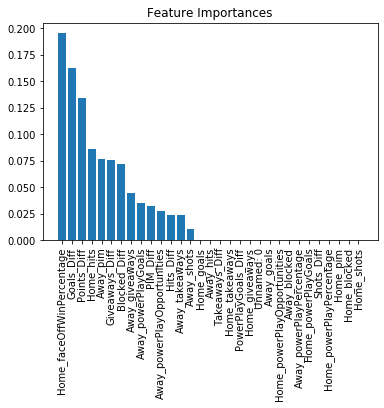

In [23]:
feature_importances = set(zip(X.columns, clf.feature_importances_))
feature_importances = pd.DataFrame(feature_importances).sort_values(1, ascending = False)
feature_importances.columns = ["Feature", "Importance"]
plt.bar(feature_importances["Feature"], feature_importances["Importance"]);
plt.xticks(rotation = 90);
plt.title("Feature Importances");

In [24]:
clf = RandomForestClassifier(random_state = 8).fit(X_train,y_train)
print("Random Forest")
print("Score: ", round(clf.score(X, y), 4))
pred = clf.predict(X_test)
print("Test Set Accuracy: ", round(metrics.accuracy_score(pred, y_test), 4))
#print(clf.feature_importances_)
#print(clf.predict_proba(X))
#fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=2)
#print(fpr, tpr, thresholds)
#metrics.auc(fpr, tpr)
scores = cross_val_score(clf, X, y, cv = 5)
#print(scores)
print("CV Mean Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# 1/29/20- 122 games
# score: .8689
# test accuracy: .4839
# accuracy: .57; .19

Random Forest
Score:  0.8993
Test Set Accuracy:  0.6053
CV Mean Accuracy: 0.65 (+/- 0.07)


In [25]:
joblib.dump(clf, "Classifier_Model.pkl");

# Everything below here was from previous version and can be deleted as seen fit to do so.

In [32]:
last_game_id = df_all_features.iloc[df_all_features.shape[0]-1].name
print(last_game_id)
game_link = f"https://statsapi.web.nhl.com/api/v1/game/{last_game_id}/feed/live"
data = API_reader(game_link)
#if data["liveData"]["gameData"]["currentPeriod"] == 0:
#    print("sleep for a hot minute")
#else:
#    print("calculate results")
print(data["gameData"]["status"]["abstractGameState"])

2019020801
Final


In [ ]:
def NHL_games_today(todays_date, print_binary = 0):
    """This function looks at all the games being played today (or input any date in 'YYY-MM-DD' format) then finds their 
    starting times, and sorts them by starting time. Then it calculates how long to wait between starting times."""
    games_links = f"https://statsapi.web.nhl.com/api/v1/schedule?startDate={todays_date}&endDate={todays_date}"
    #games_links = f"https://statsapi.web.nhl.com/api/v1/schedule?startDate=2020-01-02&endDate=2020-01-02"
    dates = API_reader(games_links)
    num_of_games = dates["totalGames"]
    games_id_list = [dates["dates"][0]["games"][i]["gamePk"] for i in range(num_of_games)]
    #Find the difference in seconds between the start times.
    if len(games_id_list) > 1:
        start_times = []
        game_start_dict = {}
        for game_id in games_id_list:
            data = API_reader(f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live")
            start_time = data["gameData"]["datetime"]["dateTime"]
            game_start_dict[str(game_id)] = start_time
            start_time = parse(start_time)
            start_times.append(start_time)
            start_times = sorted(start_times)
        delta_seconds_start_times = [(start_times[i+1]- start_times[i]).total_seconds() for i in range(len(start_times)-1)]+ [0]
    else:
        delta_seconds_start_times = [0]
    # Solution to sorting a dict found here: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    game_start_dict = {k : v for k, v in sorted(game_start_dict.items(), key=lambda item: item[1])}
    games_id_list =[int(j) for j in [k for k in game_start_dict.keys()]]
    if print_binary == 1:
        print(f"Number of Games on {todays_date}:", len(games_id_list))
        print("Game Ids: ", games_id_list)
        print(delta_seconds_start_times)
    return((games_id_list, delta_seconds_start_times))

In [ ]:
#time.sleep(36000)
game_counter = 0
Start_time_counter = 0
df = pd.DataFrame(columns = [i for i in range(30)])
#games_id_list = [2019020692]
for game_id in games_id_list:
    Period = 0 
    while Period < 1:
        game_link = f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live"
        data = API_reader(game_link)
        if data["liveData"]["linescore"]["currentPeriod"] == 1 and data["liveData"]["linescore"]["currentPeriodTimeRemaining"] == "END": 
            team_record = _team_records(game_id)
            some_columns = ["Home_team", "Away_team", "Home_wins", "Home_losses", "Home_OT", "Away_wins", "Away_losses", "Away_OT"]
            home_team_categories = list(data['liveData']['boxscore']['teams']['home']['teamStats']['teamSkaterStats'].keys())
            away_team_categories = list(data['liveData']['boxscore']['teams']['away']['teamStats']['teamSkaterStats'].keys())
            home_team_categories = [f"Home_{i}" for i in home_team_categories]
            away_team_categories = [f"Away_{i}" for i in away_team_categories]
            home_team = [data["gameData"]["teams"]["home"]["triCode"]]
            away_team = [data["gameData"]["teams"]["away"]["triCode"]]
            df.columns = some_columns + home_team_categories + away_team_categories
            away_team_stats = data['liveData']['boxscore']['teams']['away']['teamStats']['teamSkaterStats']
            home_team_stats = data['liveData']['boxscore']['teams']['home']['teamStats']['teamSkaterStats']
            home_team_values = list(home_team_stats.values())
            away_team_values = list(away_team_stats.values())
            df.loc[str(game_id)] = home_team + away_team + team_record + home_team_values + away_team_values
            Period = 1
            game_counter += 1
            df.to_csv(f"C:\\Users\\David\\OneDrive\\Documents\\OneDrive\\NHL API First period Prediction\\{todays_date}_raw.csv", index = True)
            print("Game ", str(game_counter) ,"/", str(len(games_id_list)), f"ID: {game_id} ({away_team[0]}@{home_team[0]}) completed at: ", str(datetime.today().hour), ":", str(datetime.today().minute))
            prediction = prepare_vars_for_prediction(game_id)   
            if int(prediction) == 0:
                print(f"The team that is predicted to win is: {home_team[0]}")
            else:
                print(f"The team that is predicted to win is: {away_team[0]}")
            if delta_seconds_start_times[Start_time_counter] != 0:
                print("Now sleeping for:", str(delta_seconds_start_times[Start_time_counter]/60/60), "hours.")
            time.sleep(delta_seconds_start_times[Start_time_counter])
            Start_time_counter += 1
        else:
            Period = 0
            print("Check Point: ", datetime.today().hour, ":", datetime.today().minute)
            time.sleep(180) 

In [ ]:
#Don't run this cell. it has been replaced by 'feature_engineering'
def prepare_vars_for_prediction(prep_df, specific_game_id):
    """This function prepares a teams's first period stats for prediction"""
   #df_vars_for_prediction = pd.DataFrame(columns = some_columns + home_team_categories + away_team_categories)
    df_vars_for_prediction = pd.DataFrame(columns = list(prep_df.columns))
    #df_vars_for_prediction.loc[str(specific_game_id)] = home_team + away_team + team_record + home_team_values + away_team_values
    df_vars_for_prediction.loc[str(specific_game_id)] = prep_df.loc[str(specific_game_id)]
    df_vars_for_prediction = differences(df_vars_for_prediction)
    df_vars_for_prediction["Points_Diff"] = (df_vars_for_prediction["Home_wins"]*2 - df_vars_for_prediction["Away_wins"]*2) + (df_vars_for_prediction["Home_OT"] - df_vars_for_prediction["Away_OT"])
    df_vars_for_prediction = df_vars_for_prediction.drop(columns = ["Home_team", "Away_team", "Home_wins", "Home_losses", \
                        "Home_OT","Away_wins", "Away_losses", "Away_OT", \
                          "Win_Diff", "Loss_Diff", "OT_Diff", "Away_faceOffWinPercentage"])
    df_vars_for_prediction.astype(float)
    print(df_vars_for_prediction)
    variables =  df_vars_for_prediction.loc[str(specific_game_id)]
    variables = variables.to_numpy().reshape(1,-1)
    print(variables)
    print(type(variables))
    print(variables.shape)
    return(RF_from_joblib.predict(variables))

#This is what 'varibles' looks like
#[[1 2 10 0.0 0.0 0.0 0.562 6 4 1 7 0 0 7 0.0 0.0 1.0 0.43799999999999994
#  7 5 1 9 1 3 -1 2 0.0 -1 0 -2 -3]]
#<class 'numpy.ndarray'>

#This is what df_vars_for_prediction looks like:
# Home_goals Home_pim Home_shots  Home_powerPlayPercentage  \
#2019020756          1        2         10                       0.0   

#            Home_powerPlayGoals  Home_powerPlayOpportunities  \
#2019020756                  0.0                          0.0   

#            Home_faceOffWinPercentage Home_blocked Home_takeaways  \
#2019020756                      0.562            6              4   

#           Home_giveaways  ... Away_hits Goals_Diff Shots_Diff Blocked_Diff  \
#2019020756              1  ...         9          1          3           -1   

#            PIM_Diff  PowerPlayGoals_Diff  Takeaways_Diff  Giveaways_Diff  \
#2019020756         2                  0.0              -1               0   

#           Hits_Diff Points_Diff  
#2019020756        -2          -3  

#[1 rows x 31 columns]

In [ ]:
#team_name = input("Enter your team: ")
team_name = 'BOS'
data = API_reader("https://statsapi.web.nhl.com/api/v1/teams")
team_dict = {}
for i in range(len(data["teams"])):
    team_dict[data['teams'][i]["abbreviation"]] = data['teams'][i]["id"]
team_id = team_dict[team_name]
data = API_reader(f"https://statsapi.web.nhl.com/api/v1/teams/{team_id}?expand=team.schedule.next")
specific_game_id = data["teams"][0]["nextGameSchedule"]["dates"][0]["games"][0]["gamePk"]
print(specific_game_id)